In [2]:
import torch
import captum
import torch.nn as nn

from captum.attr import IntegratedGradients, Occlusion, LayerGradCam, LayerAttribution
from captum.attr import visualization as viz
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import random_split, DataLoader
from torchvision.datasets import ImageFolder

import numpy as np
import torchvision.models as models
import torch.nn.functional as F

import os
from skimage.transform import resize
from sklearn.utils import shuffle



In [3]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

device = get_default_device()
device

device(type='cpu')

In [4]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [5]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device) # yield will stop here, perform other steps, and the resumes to the next loop/batch

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

Note: I'll have to either keep the CNN here up to date or import the model more elegantly:

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # use pretrained resnet 50
        self.resnet = models.resnet50(pretrained=False)
        # replace fully connected layer
        self.resnet.fc = nn.Sequential(
            nn.LazyLinear(2048),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(2048, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 2048),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            # return one output for binary classification with BCEWithLogitsLoss
            nn.Linear(2048, 2),
        )

    def forward(self, x):
        # squeeze to make sure dimension is compatible with BCEWithLogitsLoss
        return self.resnet(x)


model = CNN().to(device)
#checkpoint = torch.load("../models/cnn_all_unfrozen.pth", map_location=device)
checkpoint = torch.load("C:/Users/pauls/Desktop/Studium/Machine Learning for Health Care/Projekt 1/cnn_all_unfrozen.pth", map_location=device)

model.load_state_dict(checkpoint)

c:\Users\pauls\miniconda3\envs\ml4hc\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\pauls\miniconda3\envs\ml4hc\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
c:\Users\pauls\miniconda3\envs\ml4hc\lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


<All keys matched successfully>

In [8]:
# Get the path for the test folder 
# test_dir = 'C:/Users/gianf/Desktop/ETH/II_Semestre/ML4HC/ML4Healthcare/project1/task2/data/chest_xray/test'

path = r"C:\Users\pauls\Desktop\Studium\Machine Learning for Health Care\Projekt 1\heart_failure\archive\chest_xray"

test_dir = os.path.join(path, "test")

In [10]:
# define the transformation for the image
transform = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

In [11]:

# load the test dataset
test_dataset = ImageFolder(test_dir, transform=transform)
# Shuffle the test dataset
test_dataset = shuffle(test_dataset)

In [12]:
# Evaluate the model on a single image 
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    # return dataset.classes[preds[0].item()]
    return preds[0].item()
    

In [13]:
# Pick five different images from the test dataset with label 0/1, and return the index

def get_image_idx(test_dataset, n, lable):
    count = 0
    index = []
    for i in range(len(test_dataset)):
        if  count < n and test_dataset[i][1] == lable:
            index.append(i)
            count += 1
        if count == n:
            break
    return index


In [14]:
n_img = 10
idx0 = get_image_idx(test_dataset, n_img, 0)
idx1 = get_image_idx(test_dataset, n_img, 1)

For the GradCAM visualisations below, we heavily leaned on the work done under the following link: https://pytorch.org/tutorials/beginner/introyt/captumyt.html

Below we will implement the GradCAM model through the CAPTUM package. We choose the last hidden convolutional layer as the layer to operate on.

In [15]:
last_conv_layer = model.resnet.layer4[-1]
layer_gradcam = LayerGradCam(model, last_conv_layer)

We start off by plotting from idx0, i.e. patients without the disease:

Predicted: 1


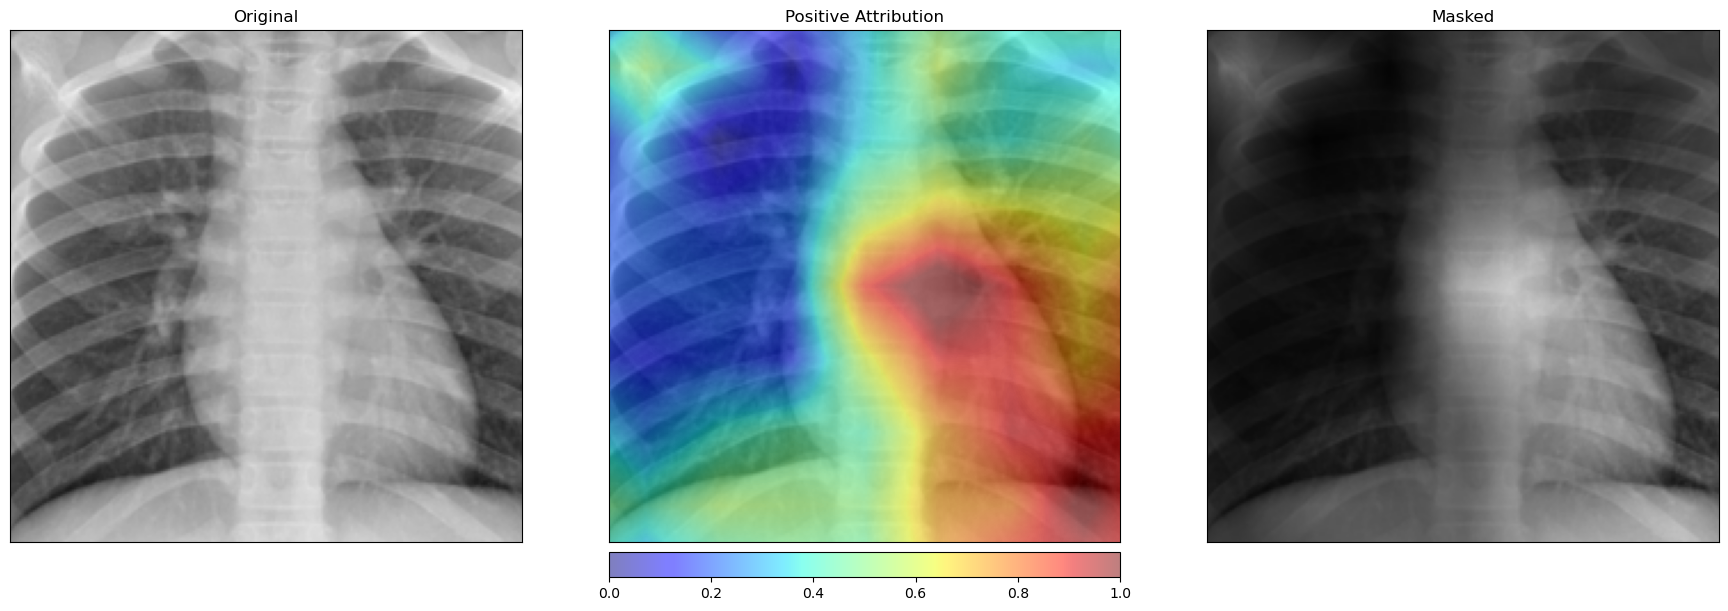

Predicted: 1


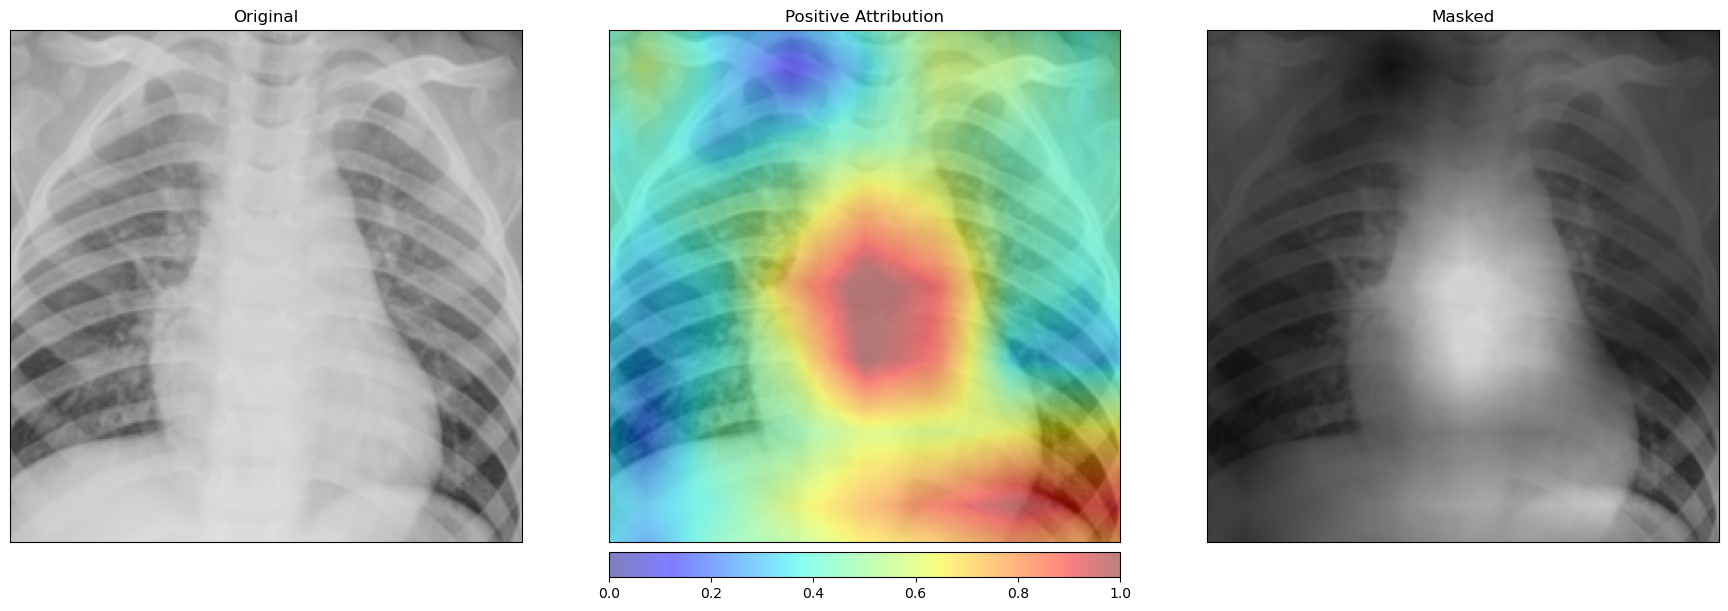

In [17]:
for i in idx0[1:3]:
    img = test_dataset[i][0]
    input_img=img.unsqueeze(0)
    pred_label_idx = predict_image(img, model)
    
    #Create the heatmap:
    attributions_lgc = layer_gradcam.attribute(input_img, target=pred_label_idx, attribute_to_layer_input=True)
    
    #This heatmap would be 7x7, so we have to rescale it:
    upsample=resize(attributions_lgc.squeeze(0).permute(1,2,0).detach().numpy(), (224,224), preserve_range=True)
    
    #We have to make some modifications so that it can be plugged into LayerAttribution.interpolate:
    torch_upsample = torch.from_numpy(upsample).permute(2,0,1)
    
    upsamp_attr_lgc = LayerAttribution.interpolate(torch_upsample.unsqueeze(0), input_img.shape[2:])
    
    print('Predicted:', pred_label_idx)
    _ = viz.visualize_image_attr_multiple(upsamp_attr_lgc[0].cpu().permute(1,2,0).detach().numpy(),
                                        img.permute(1,2,0).numpy(),
                                        ["original_image","blended_heat_map","masked_image"],
                                        ["all","positive","positive"],
                                        show_colorbar=True,
                                        titles=["Original", "Positive Attribution", "Masked"],
                                        fig_size=(18, 6),
                                        cmap='jet')    

Now we create the same plots for patients who have the disease:

Predicted: 1


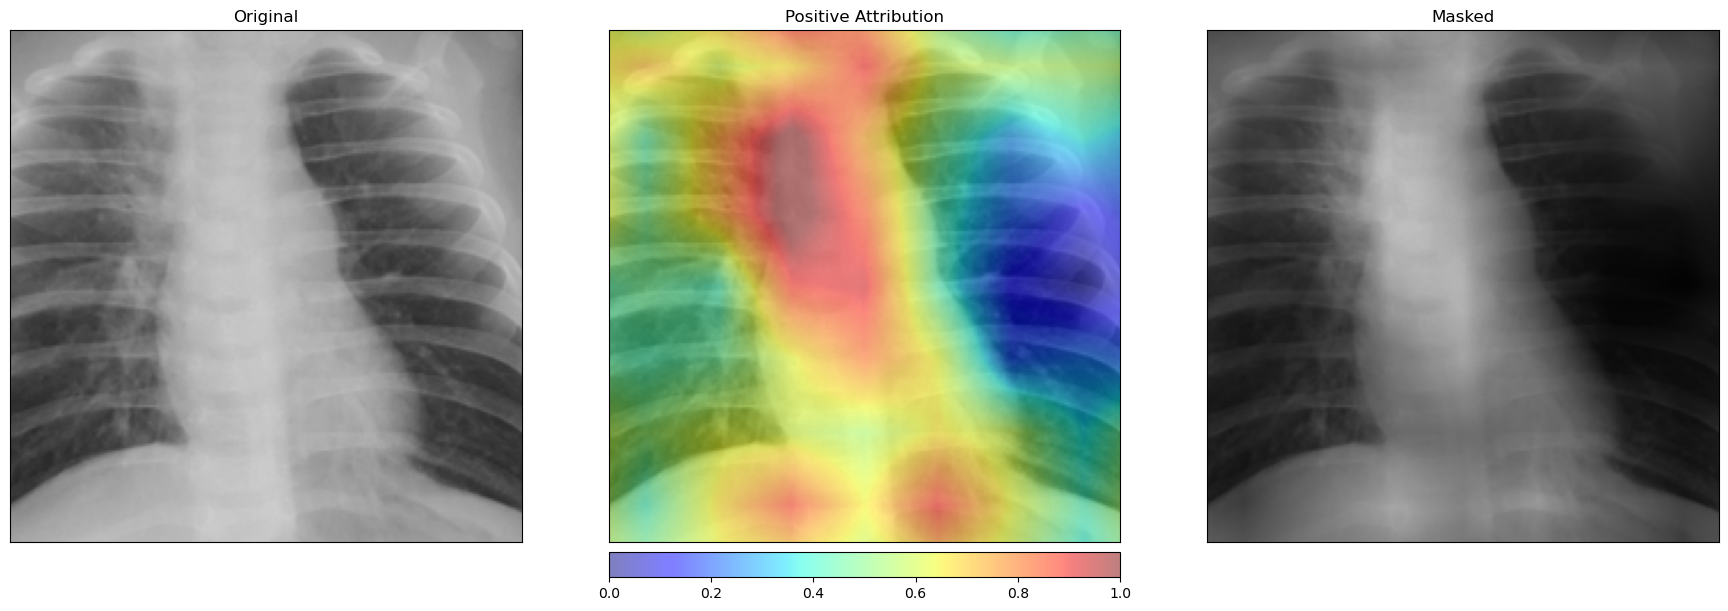

Predicted: 1


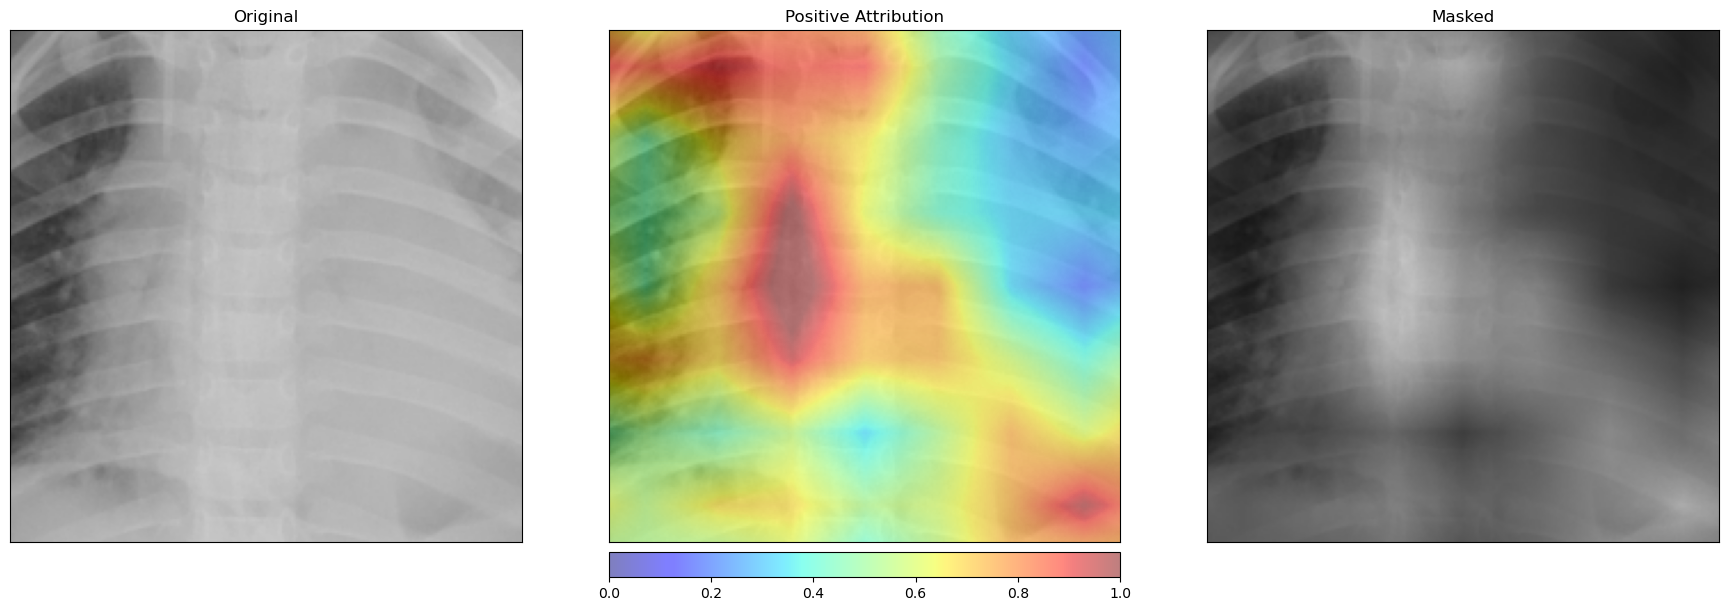

In [19]:
for i in idx1[1:3]:
    img = test_dataset[i][0]
    input_img=img.unsqueeze(0)
    pred_label_idx = predict_image(img, model)
    
    #Create the heatmap:
    attributions_lgc = layer_gradcam.attribute(input_img, target=pred_label_idx, attribute_to_layer_input=True)
    
    #This heatmap would be 7x7, so we have to rescale it:
    upsample=resize(attributions_lgc.squeeze(0).permute(1,2,0).detach().numpy(), (224,224), preserve_range=True)
    
    #We have to make some modifications so that it can be plugged into LayerAttribution.interpolate:
    torch_upsample = torch.from_numpy(upsample).permute(2,0,1)
    
    upsamp_attr_lgc = LayerAttribution.interpolate(torch_upsample.unsqueeze(0), input_img.shape[2:])
    
    print('Predicted:', pred_label_idx)
    _ = viz.visualize_image_attr_multiple(upsamp_attr_lgc[0].cpu().permute(1,2,0).detach().numpy(),
                                        img.permute(1,2,0).numpy(),
                                        ["original_image","blended_heat_map","masked_image"],
                                        ["all","positive","positive"],
                                        show_colorbar=True,
                                        titles=["Original", "Positive Attribution", "Masked"],
                                        fig_size=(18, 6),
                                        cmap='jet')    